In [132]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import random

from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

%matplotlib inline


In [133]:
# utility functions
def plot_images(img1, img2, title1='', title2=''):
    ''' 
    plot 2 images side by side. 
    image with one color channel will be plotted as grayscale image
    image with multiple color channels will be treated as BGR and will be converted to RGB before plotting
    '''
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,8))
    
    ax1.set_title(title1)
    if len(img1.shape) == 3 and img1.shape[2] == 3:
        ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    else:
        ax1.imshow(img1, cmap='gray')
    
    ax2.set_title(title2)
    if len(img2.shape) == 3 and img2.shape[2] == 3:
        ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    else:
        ax2.imshow(img2, cmap='gray')
        
def draw_line(img, pt1, pt2, color=[255, 0, 0], thickness=2):
    ''' draw a line on an image given two endpoints of the line
    '''
    cv2.line(img, (pt1[0], pt1[1]), (pt2[0], pt2[1]), color, thickness)

def draw_trapezoid(img, points):
    ''' draw a trapezoid given the four points
    '''
    draw_line(img, points[0], points[1])
    draw_line(img, points[1], points[2])
    draw_line(img, points[2], points[3])
    draw_line(img, points[3], points[0])
    


## Calibrate Camera

camera matrix [[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
distortion coefficients [[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]
done..


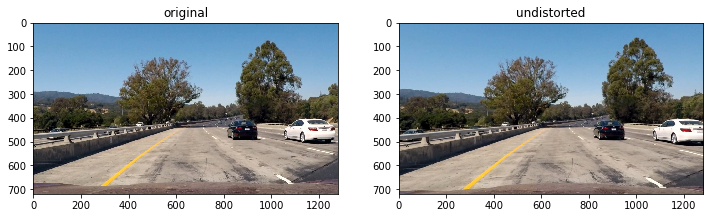

In [134]:
# determine the object points and image points with chessboard images
objpoints = []
imgpoints = []

# prepare object points
nx = 9 #number of inside corners in x
ny = 6 #number of inside corners in y
objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

fnames = glob.glob('./camera_cal/calibration*.jpg')

for fname in fnames:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
     # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

image = cv2.imread('test_images/test1.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)        

print('camera matrix', mtx)
print('distortion coefficients', dist)
print('done..')

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

# display a sample
undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
plot_images(image, undistorted_image, 'original', 'undistorted')

## Threshold Transform

In [135]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(img, thresh=(0, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(S)
    #s_binary[(H >= thresh[0]) & (H <= thresh[1])] = 1
    s_binary[(S >= thresh[0]) & (S <= thresh[1])] = 1
    return s_binary

def filter(img, show_step=False):
    ksize = 21
    #  Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', thresh=(20, 100))    
    grady = abs_sobel_thresh(image, orient='y', thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.1))
    color_binary = color_threshold(img, thresh=(90,255))
    # combine filter
    combined = np.zeros_like(color_binary)
    combined[(color_binary == 1) | ((gradx == 1) & (grady == 1) & (mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

    
#image = cv2.imread('test_images/test5.jpg')
#after = filter(image, True)
#plot_images(image, after)

'''
fnames = glob.glob('./test_images/*.jpg')
for fname in fnames:
    img = cv2.imread(fname)
    after = filter(img)
    plot_images(img, after, fname)
'''

"\nfnames = glob.glob('./test_images/*.jpg')\nfor fname in fnames:\n    img = cv2.imread(fname)\n    after = filter(img)\n    plot_images(img, after, fname)\n"

## Perspective Transform

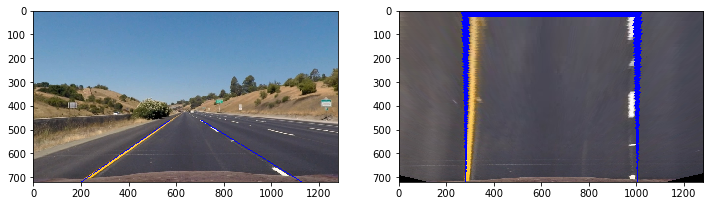

In [136]:
src = np.float32([
    (575,460),
    (705,460),
    (1130, 720),
    (200, 720)
])

dst = np.float32([
    (280, 0),
    (1000, 0),
    (1000, 720),
    (280, 720)
])

def warp(img, src, dst):
    ''' computer and apply perspective transform
    '''
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    return warped

def create_birds_eye_view(img):
    return warp(img, src, dst)

img = cv2.imread('./test_images/straight_lines1.jpg')
img = undistort(img)
draw_trapezoid(img, src)
warped = create_birds_eye_view(img)
plot_images(img, warped)

## Parameter turning

<function __main__.explore>

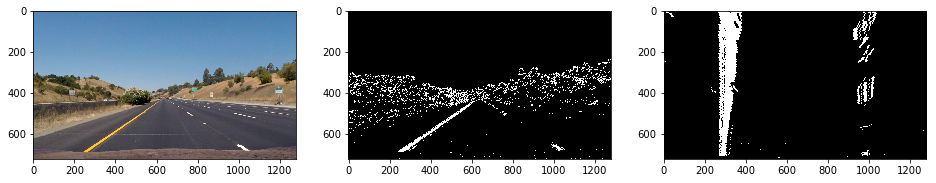

In [137]:
# use widget to interatively find optimpal parameters for image filter

image = cv2.imread('./test_images/straight_lines1.jpg')
#image = cv2.imread('./test_images/test1.jpg')

def explore(ksize=21, 
            gradx_min=20, 
            gradx_max=100, 
            grady_min=20, 
            grady_max=100, 
            mag_min=20, 
            mag_max=100, 
            dir_min=0.7, 
            dir_max=1.1, 
            color_min=150, 
            color_max=255):
    original = np.copy(image)
    gradx = abs_sobel_thresh(image, orient='x', thresh=(gradx_min, gradx_max))    
    grady = abs_sobel_thresh(image, orient='y', thresh=(grady_min, grady_max))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(mag_min, mag_max))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(dir_min, dir_max))
    color_binary = color_threshold(image, thresh=(color_min,color_max))
    # combine filter
    combined = np.zeros_like(color_binary)
    combined[(color_binary == 1) | ((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    #plt.imshow(combined, cmap='gray')
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16,16))
    ax1.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    ax2.imshow(combined, cmap='gray')
    ax3.imshow(create_birds_eye_view(combined), cmap='gray')

interact(explore, 
         ksize=(1,31,2),
         gradx_min=(0,255),
         gradx_max=(0,255),
         grady_min=(0,255),
         grady_max=(0,255),
         mag_min=(0,255),
         mag_max=(0,255),
         dir_min=(0, np.pi/2),
         dir_max=(0, np.pi/2),
         color_min=(0,255),
         color_max=(0,255))

## run the pipeline on all test images

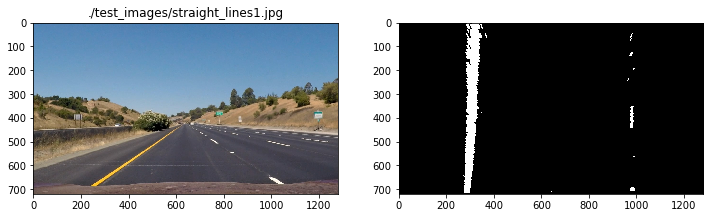

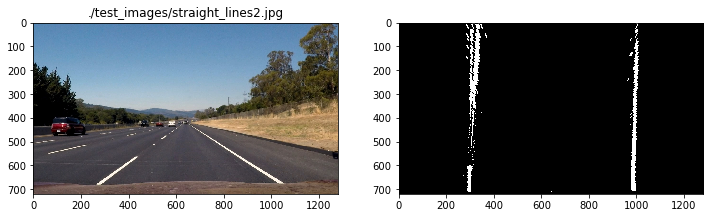

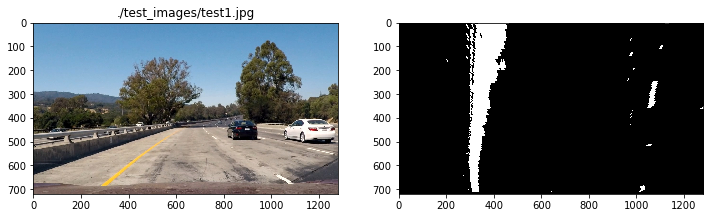

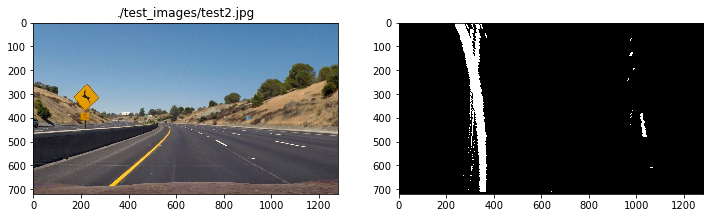

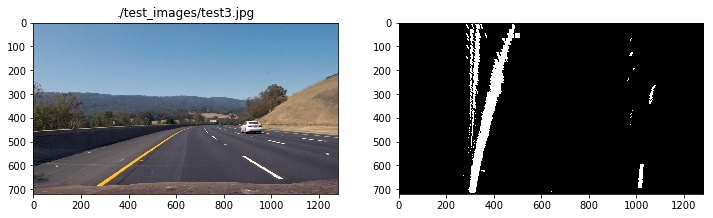

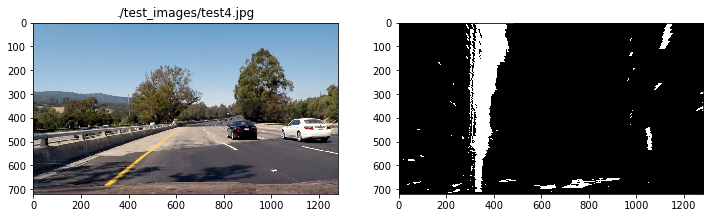

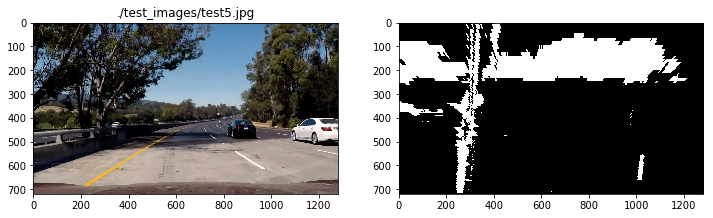

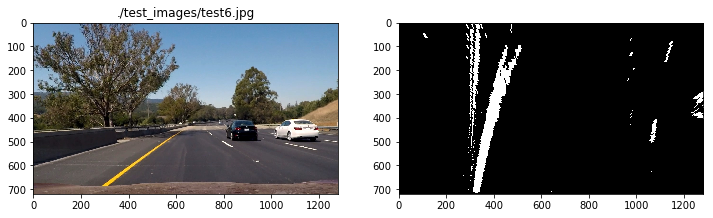

In [142]:
###### test pipeline

fnames = glob.glob('./test_images/*.jpg')

for fname in fnames:
    original = cv2.imread(fname)
    img = np.copy(original)
    img = undistort(img)
    img = filter(img)
    img = create_birds_eye_view(img)
    #draw_trapezoid(original, src)
    plot_images(original, img, fname)

## Locate Lane Lines

/Users/vincechan/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


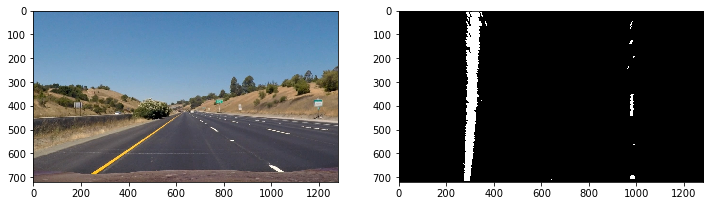

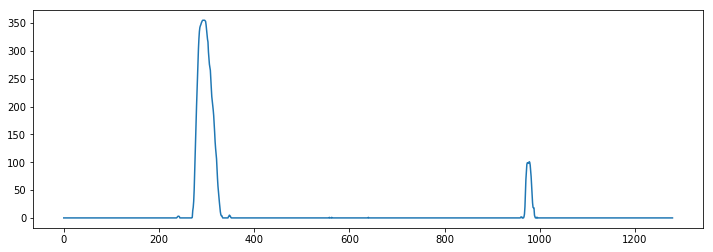

In [138]:
img = cv2.imread('./test_images/straight_lines1.jpg')
original = np.copy(img)
img = undistort(img)
img = filter(img)
img = create_birds_eye_view(img)
binary_warped = img
plot_images(original, img)

plt.figure(figsize=(12,4))
histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
plt.plot(histogram)



[276 277 278 ..., 337 338 339]
[640 640 640 ...,  79  79  79]


/Users/vincechan/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


(720, 0)

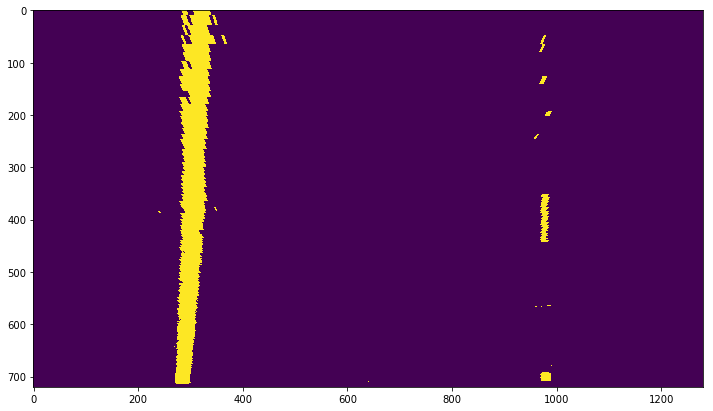

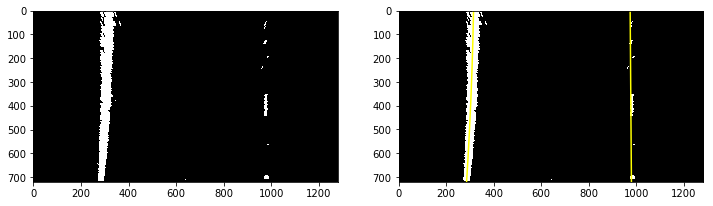

In [144]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

print(leftx)
print(lefty)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.figure(figsize=(12,8))
plt.imshow(binary_warped)

plot_images(binary_warped, binary_warped)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

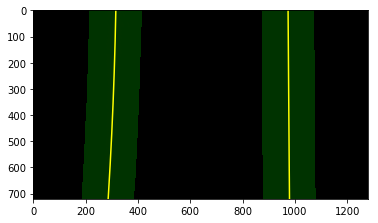

In [162]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [153]:
# curvature
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
#rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

print(len(leftx))
#print(len(lefty))
#print(len(ploty))

# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

720


TypeError: expected x and y to have same length